### Video Classification using Transformer

In [97]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp 

import torch 
import torch.nn as nn
import torch.nn.functional as F

In [98]:
mp_holist = mp.solutions.holistic 
mp_draw = mp.solutions.drawing_utils

In [99]:
def mediapipe_detection(img, model):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img.flags.writeable = False                 
    result = model.process(img)                 # Make prediction
    img.flags.writeable = True                   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    return img, result

In [100]:
def draw_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS) # Draw face connections
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS) # Draw pose connections
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw left hand connections
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS) # Draw right hand connections

In [101]:
def draw_styled_landmarks(img, result):
    mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
                             mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
                             mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
                             ) 
    # mp_draw.draw_landmarks(img, result.face_landmarks, mp_holist.FACEMESH_CONTOURS, 
    #                          mp_draw.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), # color the joint 
    #                          mp_draw.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) #color the connection
    #                          ) 
    
    mp_draw.draw_landmarks(img, result.pose_landmarks, mp_holist.POSE_CONNECTIONS,
                             mp_draw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.left_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_draw.draw_landmarks(img, result.right_hand_landmarks, mp_holist.HAND_CONNECTIONS, 
                             mp_draw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_draw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [102]:
def extract_keypoints(results):
    pose=np.array([[res.x,res.y,res.z,res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    left_hnd=np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    right_hnd=np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose,left_hnd,right_hnd,face])
# concatenating for the model to detect the sign language

In [103]:
import os 
video_dir = "C:/Users/araya/Desktop/keypoints/video_extract"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

40

In [104]:
video_list

['กฎกระทรวง.mp4',
 'กฎหมายรัฐธรรมนูญ.mp4',
 'กรมอนามัย.mp4',
 'กรรม.mp4',
 'กรรมสิทธิ์.mp4',
 'กระโดด.mp4',
 'กล้วยบวชชี.mp4',
 'กล้วยเชื่อม.mp4',
 'กังวล.mp4',
 'กีฬา.mp4',
 'น้อง.mp4',
 'เขิน.mp4',
 'เขื่อนดิน.mp4',
 'เขื่อนสิริกิติ์.mp4',
 'เข้าใจผิด.mp4',
 'เคย.mp4',
 'เครียด.mp4',
 'เครื่องปั่นดิน.mp4',
 'เครื่องหมายการค้า.mp4',
 'เจอ.mp4',
 'เจ้าหนี้.mp4',
 'เช่าซื้อ.mp4',
 'เช่าทรัพย์.mp4',
 'เซอร์เบีย.mp4',
 'เซเนกัล.mp4',
 'เซ็ง.mp4',
 'เดิน.mp4',
 'เดิมพัน.mp4',
 'เพลีย.mp4',
 'เมื่อย.mp4',
 'เม็กซิโก.mp4',
 'เฮโรอีน.mp4',
 'แกมเบีย.mp4',
 'แซมเบีย.mp4',
 'โกหก.mp4',
 'โจทก์.mp4',
 'โชจู.mp4',
 'ใกล้.mp4',
 'ไดโนเสาร์.mp4',
 'ไอซ์.mp4']

In [105]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('Data for different actions')

actions = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [106]:
actions

array(['กฎกระทรวง.mp4', 'กฎหมายรัฐธรรมนูญ.mp4', 'กรมอนามัย.mp4',
       'กรรม.mp4', 'กรรมสิทธิ์.mp4', 'กระโดด.mp4', 'กล้วยบวชชี.mp4',
       'กล้วยเชื่อม.mp4', 'กังวล.mp4', 'กีฬา.mp4', 'น้อง.mp4', 'เขิน.mp4',
       'เขื่อนดิน.mp4', 'เขื่อนสิริกิติ์.mp4', 'เข้าใจผิด.mp4', 'เคย.mp4',
       'เครียด.mp4', 'เครื่องปั่นดิน.mp4', 'เครื่องหมายการค้า.mp4',
       'เจอ.mp4', 'เจ้าหนี้.mp4', 'เช่าซื้อ.mp4', 'เช่าทรัพย์.mp4',
       'เซอร์เบีย.mp4', 'เซเนกัล.mp4', 'เซ็ง.mp4', 'เดิน.mp4',
       'เดิมพัน.mp4', 'เพลีย.mp4', 'เมื่อย.mp4', 'เม็กซิโก.mp4',
       'เฮโรอีน.mp4', 'แกมเบีย.mp4', 'แซมเบีย.mp4', 'โกหก.mp4',
       'โจทก์.mp4', 'โชจู.mp4', 'ใกล้.mp4', 'ไดโนเสาร์.mp4', 'ไอซ์.mp4'],
      dtype='<U21')

Collecting keypoint values for Training nd Testing

In [107]:
# Define the directory where your videos are stored
directory = "C:/Users/araya/Desktop/keypoints/video_extract"

In [108]:
directory

'C:/Users/araya/Desktop/keypoints/video_extract'

In [109]:
for filename in actions:
    print(directory + '/' + filename)

C:/Users/araya/Desktop/keypoints/video_extract/กฎกระทรวง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กฎหมายรัฐธรรมนูญ.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรมอนามัย.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กรรมสิทธิ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กระโดด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยบวชชี.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กล้วยเชื่อม.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กังวล.mp4
C:/Users/araya/Desktop/keypoints/video_extract/กีฬา.mp4
C:/Users/araya/Desktop/keypoints/video_extract/น้อง.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนดิน.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เขื่อนสิริกิติ์.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เข้าใจผิด.mp4
C:/Users/araya/Desktop/keypoints/video_extract/เคย.mp4
C:/Users/araya/Desktop/keypoints/video_e

In [110]:
file_paths = []
for action in actions:
    video_path = os.path.join('Data for different actions/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [111]:
def load_keypoint_sequences(file_paths):
    keypoint_sequences = []
    for file_path in file_paths:
        print(file_path)
        keypoints = np.load(file_path)
        keypoint_sequences.append(torch.tensor(keypoints, dtype=torch.float32))
    return keypoint_sequences

In [112]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
sequences

Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy
Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy
Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy
Data for different actions/กรรม.mp4/กรรม.npy
Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy
Data for different actions/กระโดด.mp4/กระโดด.npy
Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy
Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy
Data for different actions/กังวล.mp4/กังวล.npy
Data for different actions/กีฬา.mp4/กีฬา.npy
Data for different actions/น้อง.mp4/น้อง.npy
Data for different actions/เขิน.mp4/เขิน.npy
Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy
Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy
Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy
Data for different actions/เคย.mp4/เคย.npy
Data for different actions/เครียด.mp4/เครียด.npy
Data for different actions/เครื่องปั่นดิน.mp4/เครื่องปั่นดิน.npy
Data for different actions/เครื่องหมาย

[tensor([[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.4861,  0.2513, -1.3416,  ...,  0.5572,  0.2177,  0.0091],
         [ 0.4873,  0.2514, -1.3574,  ...,  0.5575,  0.2172,  0.0097],
         [ 0.4883,  0.2516, -1.3579,  ...,  0.5577,  0.2170,  0.0101]]),
 tensor([[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.4814,  0.2260, -1.3318,  ...,  0.5503,  0.1923,  0.0123],
         [ 0.4815,  0.2257, -1.3351,  ...,  0.5503,  0.1921,  0.0122],
         [ 0.4815,  0.2255, -1.3497,  ...,  0.5501,  0.1919,  0.0124]]),
 tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [113]:
print(type(sequences))
print(sequences[0].shape)
print(sequences[1].shape)
print(sequences[2].shape)
print(sequences[3].shape)
print(sequences[4].shape)
print("We can see that each row (lenght of video) is not the same size, so we need to pad them.")

<class 'list'>
torch.Size([142, 1662])
torch.Size([134, 1662])
torch.Size([151, 1662])
torch.Size([100, 1662])
torch.Size([160, 1662])
We can see that each row (lenght of video) is not the same size, so we need to pad them.


In [114]:
# Pad the sequences to the same length
from torch.nn.utils.rnn import pad_sequence
padded_sequences = pad_sequence(sequences, batch_first=True)
print(padded_sequences.shape) # (batch_size, max_sequence_length, num_keypoints)

torch.Size([40, 160, 1662])


In [115]:
print(type(padded_sequences))
print(padded_sequences[0].shape)
print(padded_sequences[1].shape)
print(padded_sequences[2].shape)
print(padded_sequences[3].shape)
print(padded_sequences[4].shape)

<class 'torch.Tensor'>
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])
torch.Size([160, 1662])


In [116]:
sequences[2] 

tensor([[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
        [ 0.5045,  0.2381, -1.1896,  ...,  0.5643,  0.2081,  0.0085],
        [ 0.5041,  0.2385, -1.1915,  ...,  0.5643,  0.2080,  0.0089],
        ...,
        [ 0.4963,  0.2307, -1.3096,  ...,  0.5624,  0.2043,  0.0127],
        [ 0.4965,  0.2308, -1.3085,  ...,  0.5625,  0.2045,  0.0126],
        [ 0.4972,  0.2312, -1.3053,  ...,  0.5633,  0.2045,  0.0128]])

In [117]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [118]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels = le.fit_transform(labels)
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int64)

In [119]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Create a custom dataset
class KeypointDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        keypoints = np.load(self.file_paths[idx])
        label = self.labels[idx]
        return torch.tensor(keypoints, dtype=torch.float32), label

In [120]:
# Create the dataset
dataset = KeypointDataset(file_paths, labels)

In [121]:
dataset

In [122]:
print(dataset.file_paths)
print(dataset.labels)

['Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy', 'Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy', 'Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy', 'Data for different actions/กรรม.mp4/กรรม.npy', 'Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy', 'Data for different actions/กระโดด.mp4/กระโดด.npy', 'Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy', 'Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy', 'Data for different actions/กังวล.mp4/กังวล.npy', 'Data for different actions/กีฬา.mp4/กีฬา.npy', 'Data for different actions/น้อง.mp4/น้อง.npy', 'Data for different actions/เขิน.mp4/เขิน.npy', 'Data for different actions/เขื่อนดิน.mp4/เขื่อนดิน.npy', 'Data for different actions/เขื่อนสิริกิติ์.mp4/เขื่อนสิริกิติ์.npy', 'Data for different actions/เข้าใจผิด.mp4/เข้าใจผิด.npy', 'Data for different actions/เคย.mp4/เคย.npy', 'Data for different actions/เครียด.mp4/เครียด.npy', 'Data for different actions/เครื่องปั่นดิน.mp4/เครื

In [123]:
# Collate function for padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True)
    return padded_sequences, torch.tensor(labels)

In [124]:
# Create the DataLoader
batch_size = 4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader

In [125]:
# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Transformer

In [126]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import f1_score

# class AttentionLayer(nn.Module):
#     def __init__(self, hidden_size):
#         super(AttentionLayer, self).__init__()
#         self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

#     def forward(self, lstm_output):
#         # lstm_output: (batch_size, sequence_length, hidden_size)
#         attention_scores = self.attention_weights(lstm_output)  # (batch_size, sequence_length, 1)
#         attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)
#         weighted_output = torch.sum(lstm_output * attention_weights, dim=1)  # (batch_size, hidden_size)
#         return weighted_output, attention_weights

In [127]:
# class Encoder(nn.Module):
#     def __init__(self, input_size, num_heads, dropout):
#         super().__init__()
#         self.multihead = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)
#         self.normalize_layer = nn.LayerNorm(normalized_shape=input_size, eps=1e-5)
#         self.fc1 = nn.Linear(input_size, input_size)
#         self.pool = nn.MaxPool2d(kernel_size=(2,1), stride=1)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         attn_output, attn_output_weights = self.multihead(x, x, x)

#         normalize_attn = self.normalize_layer(x+attn_output)

#         final_output = self.normalize_layer(self.fc1(normalize_attn)+normalize_attn)

#         final_output = self.pool(final_output)

#         return final_output

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

class Encoder(nn.Module):
    def __init__(self, input_size, num_heads, dropout, num_classes):
        super(Encoder, self).__init__()
        self.multihead = nn.MultiheadAttention(embed_dim=input_size, num_heads=num_heads)
        self.normalize_layer = nn.LayerNorm(normalized_shape=input_size, eps=1e-5)
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, num_classes)  # Output layer for classification
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)  # Changed to MaxPool1d
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x should have shape [sequence_length, batch_size, input_size] for MultiheadAttention
        attn_output, _ = self.multihead(x, x, x)  # Self-attention

        normalize_attn = self.normalize_layer(x + attn_output)  # Add & Norm
        final_output = self.normalize_layer(self.fc1(normalize_attn) + normalize_attn)  # Another Add & Norm

        # Assuming you're pooling over the sequence length (dimension 0)
        pooled_output = self.pool(final_output.permute(1, 2, 0))  # Pooling across sequence length

        pooled_output = pooled_output.permute(2, 0, 1)  # Permute back to [sequence_length, batch_size, input_size]
        pooled_output = pooled_output[-1]  # Take the last time step for classification

        output = self.fc2(pooled_output)  # Final classification layer

        return output

In [129]:
# Initialize the model, loss function, and optimizer
model = Encoder(input_size=1662, num_heads=6, dropout=0.5, num_classes=40).to(device)

In [130]:
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [131]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 13889374 (Approximately 13 Million) Parameters!


In [132]:
data_loader.dataset.labels[2]

2

In [133]:
# Training loop
# References : https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/#:~:text=In%20order%20to%20calculate%20the,tensor%20along%20a%20specified%20dimension

from sklearn.metrics import f1_score, recall_score

num_epochs = 900
loss_logger = []
accuracy_logger = []
# n_epochs = []

f1_logger = []
recall_logger = []

all_preds = []
all_labels = []

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()
    for i, (sequences, labels) in enumerate(data_loader):
        # Move data to the device
        # labels = labels.type(torch.LongTensor)   # casting to long
        sequences = sequences.to(device)
        sequences = sequences.permute(1, 0, 2)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(sequences)
        _, predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Store predictions and labels for calculating metrics
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())    # Store true labels
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss_logger.append(loss.item())
    loss_logger.append(loss.item())
    accuracy = 100 * total_correct /total_samples

    # Calculate F1 score and recall
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
    recall = recall_score(all_labels, all_preds, average='weighted')

    f1_logger.append(f1)
    recall_logger.append(recall)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} , Accuracy : {accuracy:.2f}%, F1 Score: {f1:.2f}, Recall: {recall:.2f}')
    accuracy_logger.append(accuracy)
    # n_epochs.append(epoch)

Epoch [1/900], Loss: 6.0223 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [2/900], Loss: 9.2288 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [3/900], Loss: 5.9382 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [4/900], Loss: 5.4930 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [5/900], Loss: 5.0278 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [6/900], Loss: 5.0463 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [7/900], Loss: 5.2820 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [8/900], Loss: 5.9309 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [9/900], Loss: 5.2919 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [10/900], Loss: 5.1284 , Accuracy : 0.25%, F1 Score: 0.00, Recall: 0.00
Epoch [11/900], Loss: 4.7438 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [12/900], Loss: 4.9539 , Accuracy : 0.00%, F1 Score: 0.00, Recall: 0.00
Epoch [13/900], Loss: 5.1000 , Accuracy : 0.25%, F1 Score: 0.00, Recall: 

In [134]:
loss_logger

[6.022342681884766,
 9.228824615478516,
 5.938207626342773,
 5.492990016937256,
 5.0278401374816895,
 5.046273231506348,
 5.281951904296875,
 5.9309468269348145,
 5.291881084442139,
 5.128352165222168,
 4.743772506713867,
 4.953893661499023,
 5.099965572357178,
 4.974531173706055,
 5.265983581542969,
 5.214203834533691,
 4.3852338790893555,
 4.1116228103637695,
 4.515264987945557,
 4.6440887451171875,
 3.7341012954711914,
 3.9253909587860107,
 5.160040855407715,
 4.956402778625488,
 4.521730422973633,
 4.475502014160156,
 4.214385986328125,
 3.919177532196045,
 4.583104133605957,
 4.510230541229248,
 3.2269856929779053,
 4.126834869384766,
 4.310204029083252,
 3.942462682723999,
 3.445761203765869,
 4.060242176055908,
 3.6461968421936035,
 3.845123767852783,
 3.941649913787842,
 2.6521990299224854,
 2.8096721172332764,
 2.9194765090942383,
 3.413022994995117,
 3.6451618671417236,
 3.505066394805908,
 3.014340400695801,
 3.265895128250122,
 3.449533224105835,
 3.7330727577209473,
 3.531

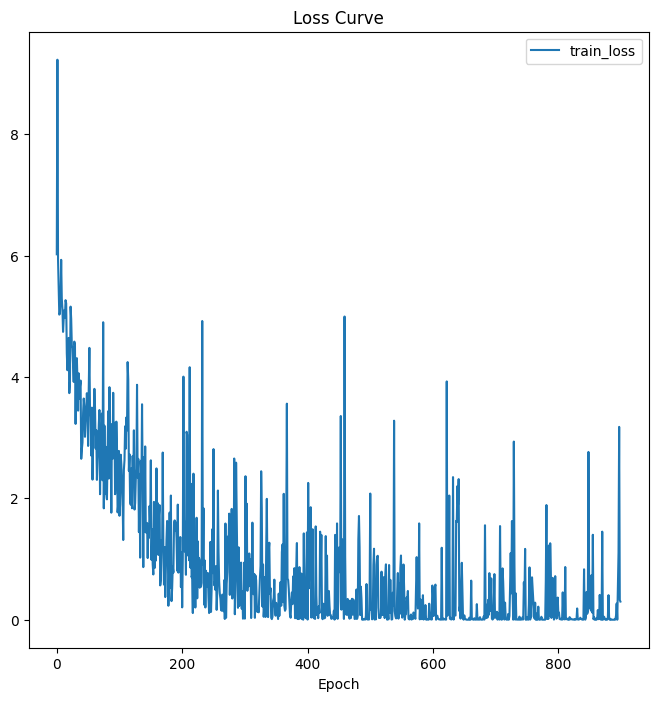

In [137]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Loss Curve")
plt.plot(loss_logger, label='train_loss')
# plt.plot(accuracy_logger,label='accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Save and Load Model

In [138]:
pad_sequence(sequences, batch_first=True)

tensor([[[ 0.4952,  0.2338, -1.3905,  ...,  0.5593,  0.2078,  0.0128],
         [ 0.5051,  0.2433, -1.3371,  ...,  0.5701,  0.2185,  0.0094],
         [ 0.4868,  0.2821, -1.4668,  ...,  0.5711,  0.2335,  0.0116],
         [ 0.4883,  0.2402, -1.1024,  ...,  0.5482,  0.2132,  0.0081]],

        [[ 0.4926,  0.2435, -1.4861,  ...,  0.5600,  0.2072,  0.0117],
         [ 0.5042,  0.2464, -1.4811,  ...,  0.5696,  0.2193,  0.0109],
         [ 0.4861,  0.2786, -1.5812,  ...,  0.5702,  0.2334,  0.0129],
         [ 0.4878,  0.2402, -1.1906,  ...,  0.5469,  0.2135,  0.0083]],

        [[ 0.4916,  0.2483, -1.4905,  ...,  0.5596,  0.2079,  0.0126],
         [ 0.5039,  0.2479, -1.4928,  ...,  0.5700,  0.2201,  0.0112],
         [ 0.4856,  0.2769, -1.6059,  ...,  0.5699,  0.2333,  0.0131],
         [ 0.4863,  0.2402, -1.1774,  ...,  0.5477,  0.2141,  0.0087]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.00

In [139]:
# Put the model in evaluation mode
model.eval()

# No need to track gradients during inference
with torch.no_grad():
    # Get the model's output (logits)
    outputs = model(padded_sequences.to(device))

# outputs = torch.softmax(outputs, dim=1)
# outputs = torch.max(outputs,1)

outputs


tensor([[ -6.2359, -11.3121,  12.5830,  ..., -14.3575,  20.6375,  19.7105],
        [ -4.7641,  -8.1665,  12.2483,  ..., -17.2629,  19.8312,  21.5494],
        [ -3.3883,  -6.7548,  12.8024,  ..., -17.9381,  19.2446,  22.4002],
        ...,
        [  4.2639,  11.6971,  -0.4409,  ..., -10.5903,  -9.1614,  -0.0678],
        [  4.4241,  12.6071,  -0.7499,  ..., -12.1123,  -9.7169,   0.9137],
        [  3.9314,  12.3485,  -0.9649,  ..., -11.4297,  -9.1487,   0.1298]],
       device='cuda:0')

In [140]:
padded_sequences

tensor([[[ 0.5013,  0.2452, -1.2167,  ...,  0.5663,  0.2188,  0.0098],
         [ 0.4997,  0.2482, -1.4690,  ...,  0.5652,  0.2181,  0.0106],
         [ 0.4984,  0.2500, -1.4853,  ...,  0.5654,  0.2185,  0.0112],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4922,  0.2382, -1.2850,  ...,  0.5578,  0.2124,  0.0094],
         [ 0.4920,  0.2405, -1.4288,  ...,  0.5571,  0.2116,  0.0099],
         [ 0.4920,  0.2409, -1.4093,  ...,  0.5567,  0.2122,  0.0098],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.5049,  0.2371, -1.2115,  ...,  0.5643,  0.2082,  0.0088],
         [ 0.5045,  0.2381, -1.1896,  ...,  0

In [141]:
file_paths = ["Data for different actions/เขิน_0.mp4/เขิน_0.npy"]

In [142]:
# Load the sequences
import torch
sequences = load_keypoint_sequences(file_paths)
# Change list to numpy array 
sequences = np.array(sequences)
# Change numpy array to tensor
sequences = torch.FloatTensor(sequences)
sequences = pad_sequence(sequences, batch_first=True)
sequences

Data for different actions/เขิน_0.mp4/เขิน_0.npy


tensor([[[ 0.4321,  0.2240, -1.4261,  ...,  0.4724,  0.1833,  0.0108],
         [ 0.4325,  0.2250, -1.4727,  ...,  0.4722,  0.1847,  0.0102],
         [ 0.4330,  0.2258, -1.4930,  ...,  0.4725,  0.1845,  0.0109],
         ...,
         [ 0.4396,  0.2238, -1.5889,  ...,  0.4802,  0.1780,  0.0139],
         [ 0.4395,  0.2238, -1.5796,  ...,  0.4802,  0.1776,  0.0141],
         [ 0.4394,  0.2234, -1.5304,  ...,  0.4799,  0.1771,  0.0144]]])

In [143]:
# Add permute for Transformer
sequences = sequences.permute(1, 0, 2)

In [144]:
outputs = model(sequences.to(device))
outputs

tensor([[  9.9180,  -1.4841,  -1.7864, -17.5345,  15.2381,  -7.6676,  13.2963,
          -2.1478,  -8.3871, -17.4969,  -1.3681,  -3.1431,  15.1041,   8.5803,
          -6.3915,  12.5934,   8.1173,   4.4034,   3.0545, -17.0220, -12.5390,
           6.0668, -16.9036, -15.2364, -15.7116,  -1.8234,  12.5988,   4.8987,
         -11.9862,  -6.2802,  -1.2158,   2.5907,  -4.5679, -18.9376,  -2.4871,
          19.4532,  16.6620,  24.6813,  -1.2265, -26.4846]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [145]:
labels = [action.split(".")[0] for action in actions]
labels

['กฎกระทรวง',
 'กฎหมายรัฐธรรมนูญ',
 'กรมอนามัย',
 'กรรม',
 'กรรมสิทธิ์',
 'กระโดด',
 'กล้วยบวชชี',
 'กล้วยเชื่อม',
 'กังวล',
 'กีฬา',
 'น้อง',
 'เขิน',
 'เขื่อนดิน',
 'เขื่อนสิริกิติ์',
 'เข้าใจผิด',
 'เคย',
 'เครียด',
 'เครื่องปั่นดิน',
 'เครื่องหมายการค้า',
 'เจอ',
 'เจ้าหนี้',
 'เช่าซื้อ',
 'เช่าทรัพย์',
 'เซอร์เบีย',
 'เซเนกัล',
 'เซ็ง',
 'เดิน',
 'เดิมพัน',
 'เพลีย',
 'เมื่อย',
 'เม็กซิโก',
 'เฮโรอีน',
 'แกมเบีย',
 'แซมเบีย',
 'โกหก',
 'โจทก์',
 'โชจู',
 'ใกล้',
 'ไดโนเสาร์',
 'ไอซ์']

In [146]:
# Change from tensor to numpy arrat
outputs = outputs.cpu().detach().numpy()

In [147]:
outputs

array([[  9.91805  ,  -1.4841205,  -1.7864311, -17.534548 ,  15.23809  ,
         -7.667609 ,  13.296325 ,  -2.147827 ,  -8.387133 , -17.496902 ,
         -1.3681191,  -3.14309  ,  15.104138 ,   8.580265 ,  -6.3915052,
         12.593382 ,   8.117307 ,   4.4034295,   3.0545259, -17.021963 ,
        -12.539035 ,   6.066791 , -16.903622 , -15.2363825, -15.711608 ,
         -1.8233793,  12.598776 ,   4.898715 , -11.986248 ,  -6.28022  ,
         -1.215777 ,   2.5906634,  -4.567902 , -18.93756  ,  -2.4871082,
         19.453245 ,  16.662031 ,  24.681276 ,  -1.2264605, -26.484644 ]],
      dtype=float32)

In [148]:
for idx, word in enumerate(outputs):
    # max_value = torch.max(outputs)
    list_outputs = max(outputs)
    print(list_outputs)
    # print(max_value)
    # print(max_value.detach().numpy())

[  9.91805    -1.4841205  -1.7864311 -17.534548   15.23809    -7.667609
  13.296325   -2.147827   -8.387133  -17.496902   -1.3681191  -3.14309
  15.104138    8.580265   -6.3915052  12.593382    8.117307    4.4034295
   3.0545259 -17.021963  -12.539035    6.066791  -16.903622  -15.2363825
 -15.711608   -1.8233793  12.598776    4.898715  -11.986248   -6.28022
  -1.215777    2.5906634  -4.567902  -18.93756    -2.4871082  19.453245
  16.662031   24.681276   -1.2264605 -26.484644 ]


In [149]:
index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)
index_max

37

In [150]:
print(labels[index_max])

ใกล้


In [151]:
correct = 0
num_clip = 0
for clip in labels:
    # print(clip)
    file_paths = [f"Data for different actions/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)
    sequences = sequences.permute(1, 0, 2)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Data for different actions/กฎกระทรวง.mp4/กฎกระทรวง.npy
Input : กฎกระทรวง Predicted : กฎกระทรวง
Data for different actions/กฎหมายรัฐธรรมนูญ.mp4/กฎหมายรัฐธรรมนูญ.npy
Input : กฎหมายรัฐธรรมนูญ Predicted : กฎหมายรัฐธรรมนูญ
Data for different actions/กรมอนามัย.mp4/กรมอนามัย.npy
Input : กรมอนามัย Predicted : กรมอนามัย
Data for different actions/กรรม.mp4/กรรม.npy
Input : กรรม Predicted : กังวล
Data for different actions/กรรมสิทธิ์.mp4/กรรมสิทธิ์.npy
Input : กรรมสิทธิ์ Predicted : กรรมสิทธิ์
Data for different actions/กระโดด.mp4/กระโดด.npy
Input : กระโดด Predicted : กรมอนามัย
Data for different actions/กล้วยบวชชี.mp4/กล้วยบวชชี.npy
Input : กล้วยบวชชี Predicted : กล้วยบวชชี
Data for different actions/กล้วยเชื่อม.mp4/กล้วยเชื่อม.npy
Input : กล้วยเชื่อม Predicted : กรรมสิทธิ์
Data for different actions/กังวล.mp4/กังวล.npy
Input : กังวล Predicted : กังวล
Data for different actions/กีฬา.mp4/กีฬา.npy
Input : กีฬา Predicted : กีฬา
Data for different actions/น้อง.mp4/น้อง.npy
Input : น้อง Predicted : น

In [152]:
print(labels)

['กฎกระทรวง', 'กฎหมายรัฐธรรมนูญ', 'กรมอนามัย', 'กรรม', 'กรรมสิทธิ์', 'กระโดด', 'กล้วยบวชชี', 'กล้วยเชื่อม', 'กังวล', 'กีฬา', 'น้อง', 'เขิน', 'เขื่อนดิน', 'เขื่อนสิริกิติ์', 'เข้าใจผิด', 'เคย', 'เครียด', 'เครื่องปั่นดิน', 'เครื่องหมายการค้า', 'เจอ', 'เจ้าหนี้', 'เช่าซื้อ', 'เช่าทรัพย์', 'เซอร์เบีย', 'เซเนกัล', 'เซ็ง', 'เดิน', 'เดิมพัน', 'เพลีย', 'เมื่อย', 'เม็กซิโก', 'เฮโรอีน', 'แกมเบีย', 'แซมเบีย', 'โกหก', 'โจทก์', 'โชจู', 'ใกล้', 'ไดโนเสาร์', 'ไอซ์']


In [153]:
import os 
video_dir = "C:/Users/araya/Desktop/augments"
video_list = []
video_list = os.listdir(video_dir)

len(video_list)

80

In [154]:
# Path for exported data, numpy arrays
Model_Data=os.path.join('../MediaPipe/Test')

actions_test = np.array(video_list)

no_of_seqs = 1

# 30 frames in length
seq_length = 160

In [155]:
labels_test = [action.split(".")[0] for action in actions_test]
labels_test

['กฎกระทรวง_0',
 'กฎกระทรวง_1',
 'กฎหมายรัฐธรรมนูญ_0',
 'กฎหมายรัฐธรรมนูญ_1',
 'กรมอนามัย_0',
 'กรมอนามัย_1',
 'กรรม_0',
 'กรรม_1',
 'กรรมสิทธิ์_0',
 'กรรมสิทธิ์_1',
 'กระโดด_0',
 'กระโดด_1',
 'กล้วยบวชชี_0',
 'กล้วยบวชชี_1',
 'กล้วยเชื่อม_0',
 'กล้วยเชื่อม_1',
 'กังวล_0',
 'กังวล_1',
 'กีฬา_0',
 'กีฬา_1',
 'น้อง_0',
 'น้อง_1',
 'เขิน_0',
 'เขิน_1',
 'เขื่อนดิน_0',
 'เขื่อนดิน_1',
 'เขื่อนสิริกิติ์_0',
 'เขื่อนสิริกิติ์_1',
 'เข้าใจผิด_0',
 'เข้าใจผิด_1',
 'เคย_0',
 'เคย_1',
 'เครียด_0',
 'เครียด_1',
 'เครื่องปั่นดิน_0',
 'เครื่องปั่นดิน_1',
 'เครื่องหมายการค้า_0',
 'เครื่องหมายการค้า_1',
 'เจอ_0',
 'เจอ_1',
 'เจ้าหนี้_0',
 'เจ้าหนี้_1',
 'เช่าซื้อ_0',
 'เช่าซื้อ_1',
 'เช่าทรัพย์_0',
 'เช่าทรัพย์_1',
 'เซอร์เบีย_0',
 'เซอร์เบีย_1',
 'เซเนกัล_0',
 'เซเนกัล_1',
 'เซ็ง_0',
 'เซ็ง_1',
 'เดิน_0',
 'เดิน_1',
 'เดิมพัน_0',
 'เดิมพัน_1',
 'เพลีย_0',
 'เพลีย_1',
 'เมื่อย_0',
 'เมื่อย_1',
 'เม็กซิโก_0',
 'เม็กซิโก_1',
 'เฮโรอีน_0',
 'เฮโรอีน_1',
 'แกมเบีย_0',
 'แกมเบีย_1',
 'แซมเบีย_0',
 'แซมเบี

In [156]:
file_paths = []
for action in actions_test:
    video_path = os.path.join('Test/', action)
    # print(video_path)
    # print(action)
    file_paths.append(video_path + '/' + action.split(".")[0] + ".npy")
print(file_paths)

['Test/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy', 'Test/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy', 'Test/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy', 'Test/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy', 'Test/กรมอนามัย_0.mp4/กรมอนามัย_0.npy', 'Test/กรมอนามัย_1.mp4/กรมอนามัย_1.npy', 'Test/กรรม_0.mp4/กรรม_0.npy', 'Test/กรรม_1.mp4/กรรม_1.npy', 'Test/กรรมสิทธิ์_0.mp4/กรรมสิทธิ์_0.npy', 'Test/กรรมสิทธิ์_1.mp4/กรรมสิทธิ์_1.npy', 'Test/กระโดด_0.mp4/กระโดด_0.npy', 'Test/กระโดด_1.mp4/กระโดด_1.npy', 'Test/กล้วยบวชชี_0.mp4/กล้วยบวชชี_0.npy', 'Test/กล้วยบวชชี_1.mp4/กล้วยบวชชี_1.npy', 'Test/กล้วยเชื่อม_0.mp4/กล้วยเชื่อม_0.npy', 'Test/กล้วยเชื่อม_1.mp4/กล้วยเชื่อม_1.npy', 'Test/กังวล_0.mp4/กังวล_0.npy', 'Test/กังวล_1.mp4/กังวล_1.npy', 'Test/กีฬา_0.mp4/กีฬา_0.npy', 'Test/กีฬา_1.mp4/กีฬา_1.npy', 'Test/น้อง_0.mp4/น้อง_0.npy', 'Test/น้อง_1.mp4/น้อง_1.npy', 'Test/เขิน_0.mp4/เขิน_0.npy', 'Test/เขิน_1.mp4/เขิน_1.npy', 'Test/เขื่อนดิน_0.mp4/เขื่อนดิน_0.npy', 'Test/เขื่อนดิน_1.mp4/เขื่อนดิน_1.npy', 'Test/เขื่อนสิริกิติ์_0

In [157]:
correct = 0
num_clip = 0
for clip in labels_test:
    # print(clip)
    file_paths = [f"Test/{clip}.mp4/{clip}.npy"]
    # print(file_paths)

    sequences = load_keypoint_sequences(file_paths)
    # Change list to numpy array 
    sequences = np.array(sequences)
    # Change numpy array to tensor
    sequences = torch.FloatTensor(sequences)
    sequences = pad_sequence(sequences, batch_first=True)
    sequences = sequences.permute(1, 0, 2)

    outputs = model(sequences.to(device))

    for idx, word in enumerate(outputs):
        # max_value = torch.max(outputs)
        list_outputs = max(outputs)

    index_max = max(range(len(list_outputs)), key=list_outputs.__getitem__)

    print(f"Input : {clip} Predicted : {labels[index_max]}")

    if clip == labels[index_max]:
        correct = correct+1
    
    num_clip = num_clip + 1 

print(f"Correct Predicted on Training set : {correct} Corrct percentage : {correct*100/num_clip}%")

Test/กฎกระทรวง_0.mp4/กฎกระทรวง_0.npy
Input : กฎกระทรวง_0 Predicted : เขื่อนดิน
Test/กฎกระทรวง_1.mp4/กฎกระทรวง_1.npy
Input : กฎกระทรวง_1 Predicted : กล้วยบวชชี
Test/กฎหมายรัฐธรรมนูญ_0.mp4/กฎหมายรัฐธรรมนูญ_0.npy
Input : กฎหมายรัฐธรรมนูญ_0 Predicted : กรมอนามัย
Test/กฎหมายรัฐธรรมนูญ_1.mp4/กฎหมายรัฐธรรมนูญ_1.npy
Input : กฎหมายรัฐธรรมนูญ_1 Predicted : กฎหมายรัฐธรรมนูญ
Test/กรมอนามัย_0.mp4/กรมอนามัย_0.npy
Input : กรมอนามัย_0 Predicted : เขื่อนดิน
Test/กรมอนามัย_1.mp4/กรมอนามัย_1.npy
Input : กรมอนามัย_1 Predicted : กรมอนามัย
Test/กรรม_0.mp4/กรรม_0.npy
Input : กรรม_0 Predicted : ไดโนเสาร์
Test/กรรม_1.mp4/กรรม_1.npy
Input : กรรม_1 Predicted : กังวล
Test/กรรมสิทธิ์_0.mp4/กรรมสิทธิ์_0.npy
Input : กรรมสิทธิ์_0 Predicted : เดิน
Test/กรรมสิทธิ์_1.mp4/กรรมสิทธิ์_1.npy
Input : กรรมสิทธิ์_1 Predicted : กรมอนามัย
Test/กระโดด_0.mp4/กระโดด_0.npy
Input : กระโดด_0 Predicted : โจทก์
Test/กระโดด_1.mp4/กระโดด_1.npy
Input : กระโดด_1 Predicted : กรมอนามัย
Test/กล้วยบวชชี_0.mp4/กล้วยบวชชี_0.npy
Input : กล้วยบวชชี

: 